<a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/Taller_4/Taller_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 4
- Brayan Avendaño
- Jony Cardenas Herrera

### Tarea:

- Aplicar el método de KDE para remplazar las funciones de probabilidad por las generadas por el método de KDE ajustando de manera automática el parámetro "bandwidth" del KDE mediante el método de validación cruzada

- Optimizar el calculo del error


### Binary Signal Detection

Sets representing a finite number of indexed objects/states or relationships (symbols)

$
		{\textrm{Tx: } \{p(a_n)\}: {\bm{a}} }\longrightarrow {\textrm{Cx: }y = {\bm{a}} +\eta :\mathcal{N}_{\eta}(0,\sigma_{\eta}) }\longrightarrow {\textrm{Rx: } \textrm{compare: }\operatorname{M}({\bm{a}},\bm{\hat{a}})\Rightarrow\{p(y|a_n)\}}
		$

In [30]:
import numpy as np
import math

from scipy import signal
from scipy.signal import lti
from scipy.integrate import quad
import scipy.stats
from scipy.fft import fft , fftfreq ,fftshift
import seaborn as sns

import matplotlib.pyplot as plt  # data plotting
from matplotlib import rcParams

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

rcParams['figure.figsize']     = [15,6]
rcParams['lines.markersize']   = 9         # marker size in points
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.dpi']     = 180

from matplotlib import colors
from ipywidgets import interact


Histogram computation

In [31]:
def coloredhist(X, plot=None):

    """
    Crea un histograma coloreado en función de la frecuencia de los valores.

    Parámetros:
    - X: Datos a graficar.
    - plot: Índice del gráfico.
    """
    Nbins = int(1 + 3.322*np.log2(len(X)))  # Cálculo del número de bins usando la regla de Sturges
    # Creación del histograma
    if plot != None:
        n, bins, patches = ax[plot].hist(X, bins=Nbins, density=True)
    else: 
        n, bins, patches = ax.hist(X, bins=Nbins, density=True)
    # Normalización de las frecuencias para determinar colores
    fracs = n / n.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    # Asignación de colores según la frecuencia relativa
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.grid()  # Añadir rejilla al gráfico
    return


In [32]:
# Funciones para calcular la pdf de una distribución normal con media positiva y negativa
def normal_distribution_function_r(x,mean,std):
    value = scipy.stats.norm.pdf(x, mean, std)  # Calcular la pdf con media positiva
    return value

def normal_distribution_function_l(x,mean,std):
    value = scipy.stats.norm.pdf(x, -mean, std)  # Calcular la pdf con media negativa
    return value

In [33]:
def norMaxMin(data):
    """
    Normaliza los datos basándose en el valor mínimo y máximo.

    Parámetros:
    - data: Datos a normalizar.

    Retorna:
    - Datos normalizados.
    """
    min_value = np.min(data)  # Encuentra el valor mínimo en los datos
    max_value = np.max(data)  # Encuentra el valor máximo en los datos
    # Normaliza los datos usando los valores mínimo y máximo
    return (data - min_value) / (max_value - min_value)


In [34]:
import os  # Importa el módulo os para interactuar con el sistema operativo

def clearConsole():
    """Limpia la consola o terminal."""
    command = 'clear'  # Comando por defecto para sistemas Unix/Linux
    # Si el sistema operativo es Windows, usa el comando 'cls'
    if os.name in ('nt', 'dos'):
        command = 'cls'
    os.system(command)  # Ejecuta el comando para limpiar la consola

In [35]:
def generate_data(Nsample,seed=17):
    # Fix the seed to reproduce the results
    rand = np.random.RandomState(seed)
    x = []
    dat = rand.lognormal(0, np.pi/10, Nsample)
    x = np.concatenate((x, dat))
    dat = rand.normal(np.pi, 1, Nsample)
    x = np.concatenate((x, dat))
    return x

#### Tx
message = $\{a_n{\in }\mathbb{R}:n {\in} N\}$ --  {alphabet}

$\{p_i\in\mathbb{R}[0,1]\}$

In [36]:
clearConsole()

# Generación de datos simbólicos
a1 = 1       # Valor del símbolo a1
a0 = -1      # Valor del símbolo a0
Nsamples = 20 # Muestras de tiempo por símbolo
# Probabilidades de los símbolos
p_0 = 0.9
p_1 = 1 - p_0

Nsymbols = 100  # Número total de símbolos
N = Nsymbols * Nsamples  # Número total de muestras

# Genera una secuencia de símbolos basados en las probabilidades dadas
data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
# Repite cada símbolo según el número de muestras por símbolo
data = np.concatenate([[v]*Nsamples for v in data])
message = data  # Almacena la secuencia completa en la variable 'message'



#### Cx
Channel simulation: Additive White Gaussian Noise: $\eta(t),$ with $\mathbb{E}\{\eta(t)\}=0$

In [37]:
#luego de haber aplicado el método de Cross Validation y verificar su funcionamiento, se identificó que este 
# presenta un costo computacional muy alto, por ello se de propone la implementación
# de la regla de Silverman la cual genera resultados mucho mas rápidos pero un poco menos precisos

def kde_function(signal_x,eval_points=None,method="Silverman",res=500):
    """
    Aplica el método de KDE gaussiano a la señal proporcionada y ajusta
    automáticamente el ancho de banda mediante una búsqueda en la cuadrícula.

    Parámetros:
    - signal: Señal a la que se aplica KDE.
    - eval_points: puntos de evaluación
    - method: método

    Retorna:
    - eval_points: Vector de evaluación.
    - y_sp: Función de densidad estimada en los puntos de evaluación.
    """
    if eval_points is None:
        eval_points = np.linspace(np.min(signal_x), np.max(signal_x),res)

    if method == 'Silverman':
        n = len(signal_x)
        sigma = np.std(signal_x)
        optimal_bandwidth = (4 / (3 * n)) ** (1 / 5) * sigma

        print(f'Method:{method}\nOptimal bandwidth: {optimal_bandwidth:.2f}')
        kde = scipy.stats.gaussian_kde(signal_x, bw_method=optimal_bandwidth)
        y_sp = kde.pdf(eval_points)

    elif method == 'Cross Validation':
        # Define los posibles valores para el ancho de banda
        bandwidths = np.arange(0.05, 2, 0.05)

        # Crea y configura el objeto para la búsqueda en la cuadrícula
        kde = KernelDensity(kernel='gaussian')

        grid = GridSearchCV(kde, {'bandwidth': bandwidths})
        grid.fit(signal_x.reshape(-1, 1))
        # Obtiene el mejor estimador y su ancho de banda óptimo
        kde_optimal = grid.best_estimator_
        optimal_bandwidth = kde_optimal.bandwidth
        print(f'Optimal bandwidth: {optimal_bandwidth:.2f}')

        log_dens = kde_optimal.score_samples(eval_points.reshape(-1, 1))
        y_sp = np.exp(log_dens)
    
    else: return

    return (eval_points, y_sp)

Method:Silverman
Optimal bandwidth: 0.23


(0.0, 2000.0)

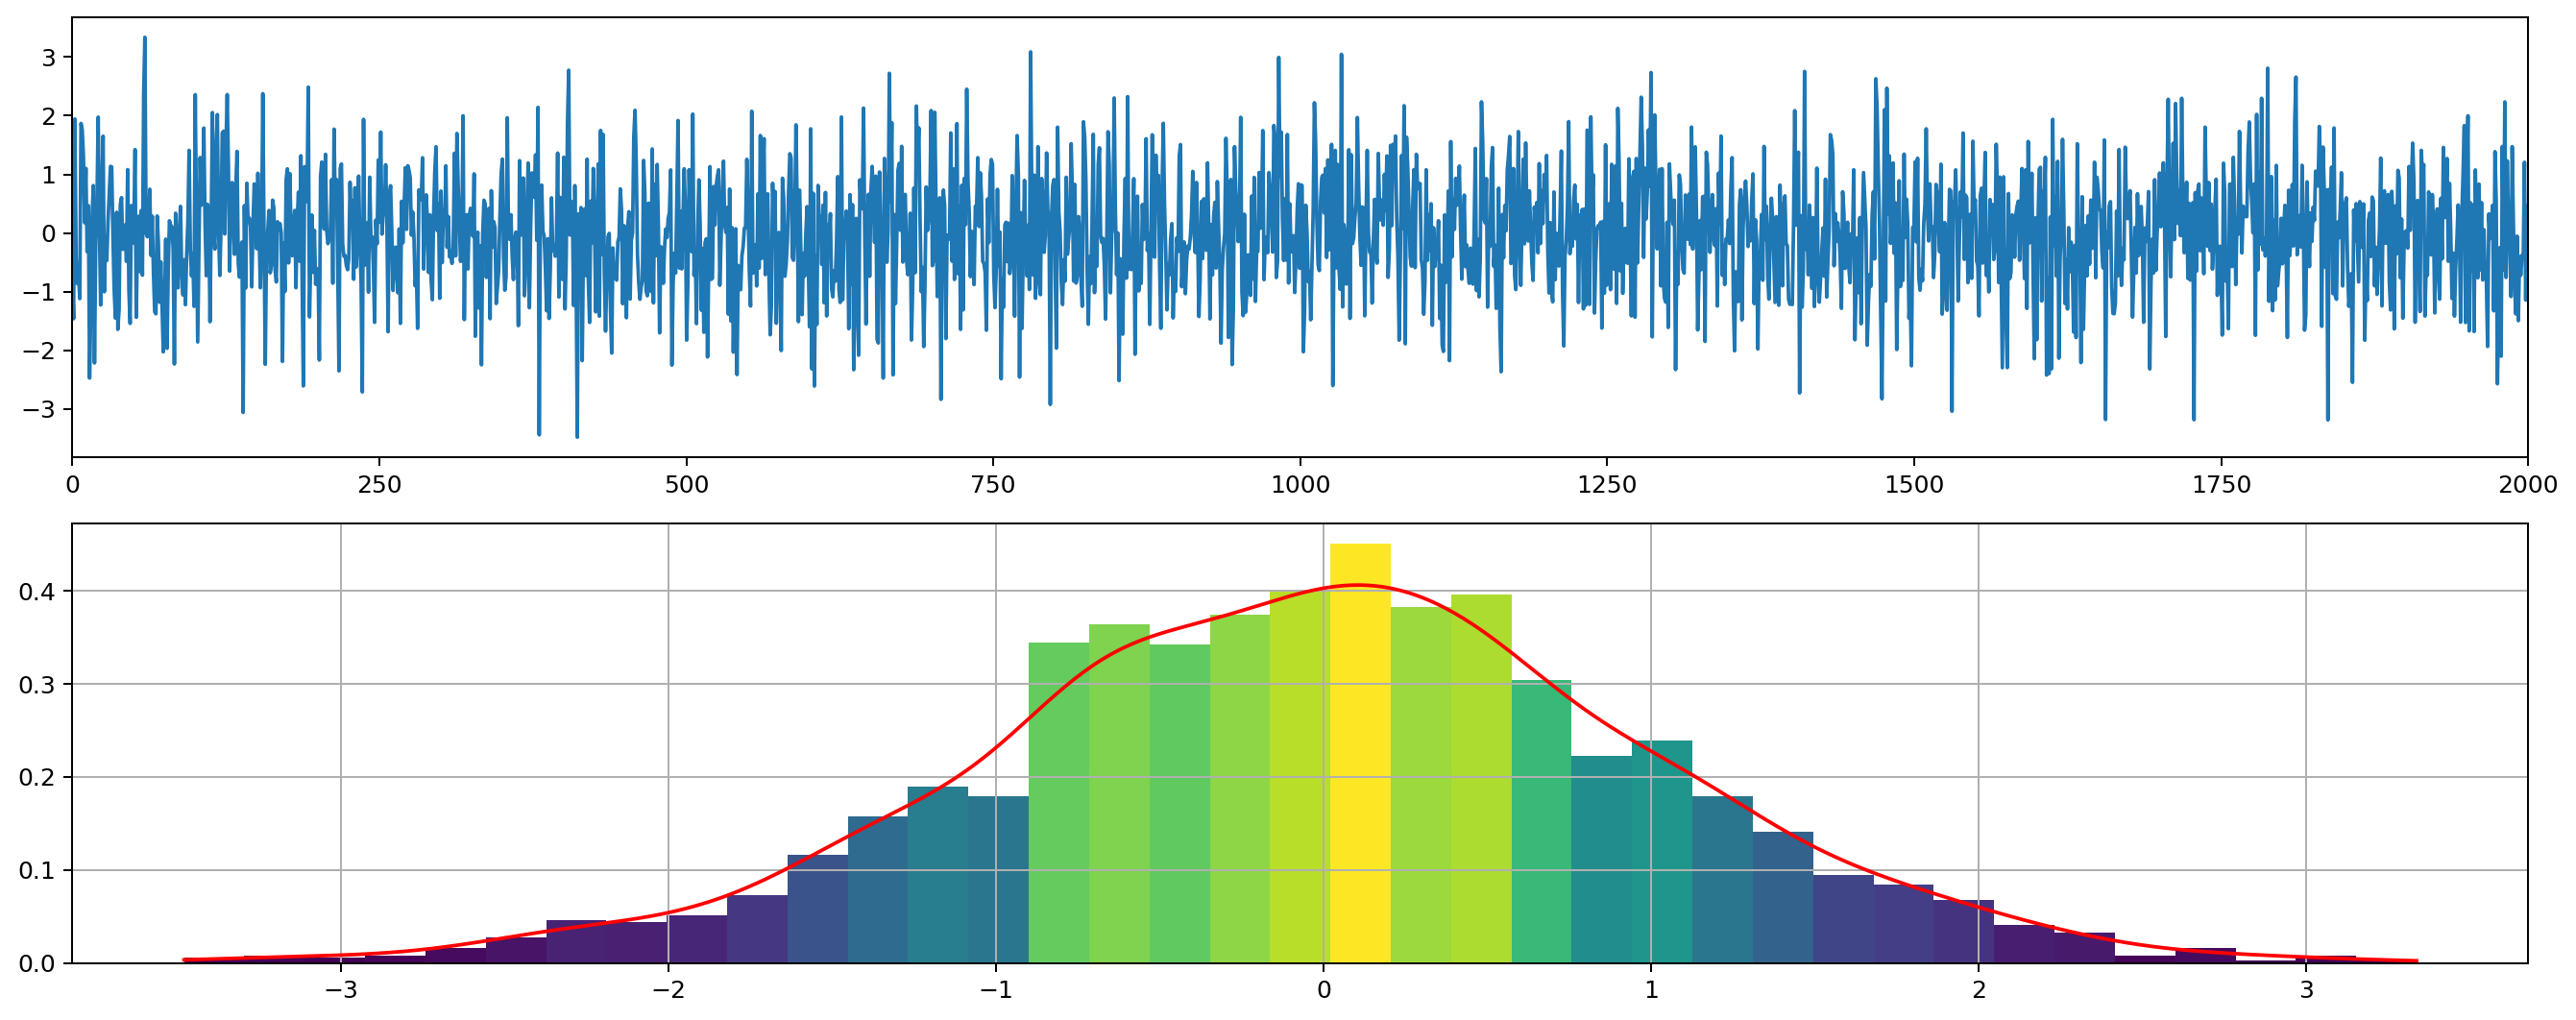

In [38]:
# Definición del vector de tiempo
time = np.linspace(0, N, N)
# Cálculo del número de bins usando la regla de Sturges
Nbins = int(1 + 3.322*np.log2(len(data)))
weight = np.ones_like(message) / N  # Pesos para el histograma

# Creación de gráficos
fig, ax = plt.subplots(2, 1, tight_layout=True)

# Generación de ruido gaussiano de media cero
σ2 = 1  # Varianza del ruido
noise = np.random.normal(0, σ2, N)

#ruido como una distribucion raice np.rice



# Estimación de la pdf del ruido
x_train  = generate_data(Nsamples)[:, np.newaxis]

pdf_x, pdf_y = kde_function(noise) #,method='Cross Validation')

# Visualización del ruido y su pdf
ax[0].plot(time, noise)
ax[1].plot(pdf_x, pdf_y, "-r")
coloredhist(noise, plot=1)
ax[0].set_xlim(0, len(message))


In [39]:
#Chi-Square Normality Test
from scipy import stats

def Test_Chi_Square(data):
    print('Chi-Square Test')
    stat_3, p_3 = stats.chisquare(data)
    x_3 = False
    print(f"stat= {round(stat_3,3)}, p= {round(p_3,5)}")
    if p_3 > 0.05:
        x_3 = True
        print("Probably Gaussian")
    else:
        print("Probably not Gaussian")
    return stat_3, p_3, x_3

Test_Chi_Square(message)

Chi-Square Test
stat= -900.0, p= 1.0
Probably Gaussian


(-900.0000000000002, 1.0, True)

Additive Gaussian Channel
$y(t) = \sum_{\forall k}{{a}_n}\operatorname{rect}_{\delta t}(t-k\delta t) +\eta(t)$

Method:Silverman
Optimal bandwidth: 0.27


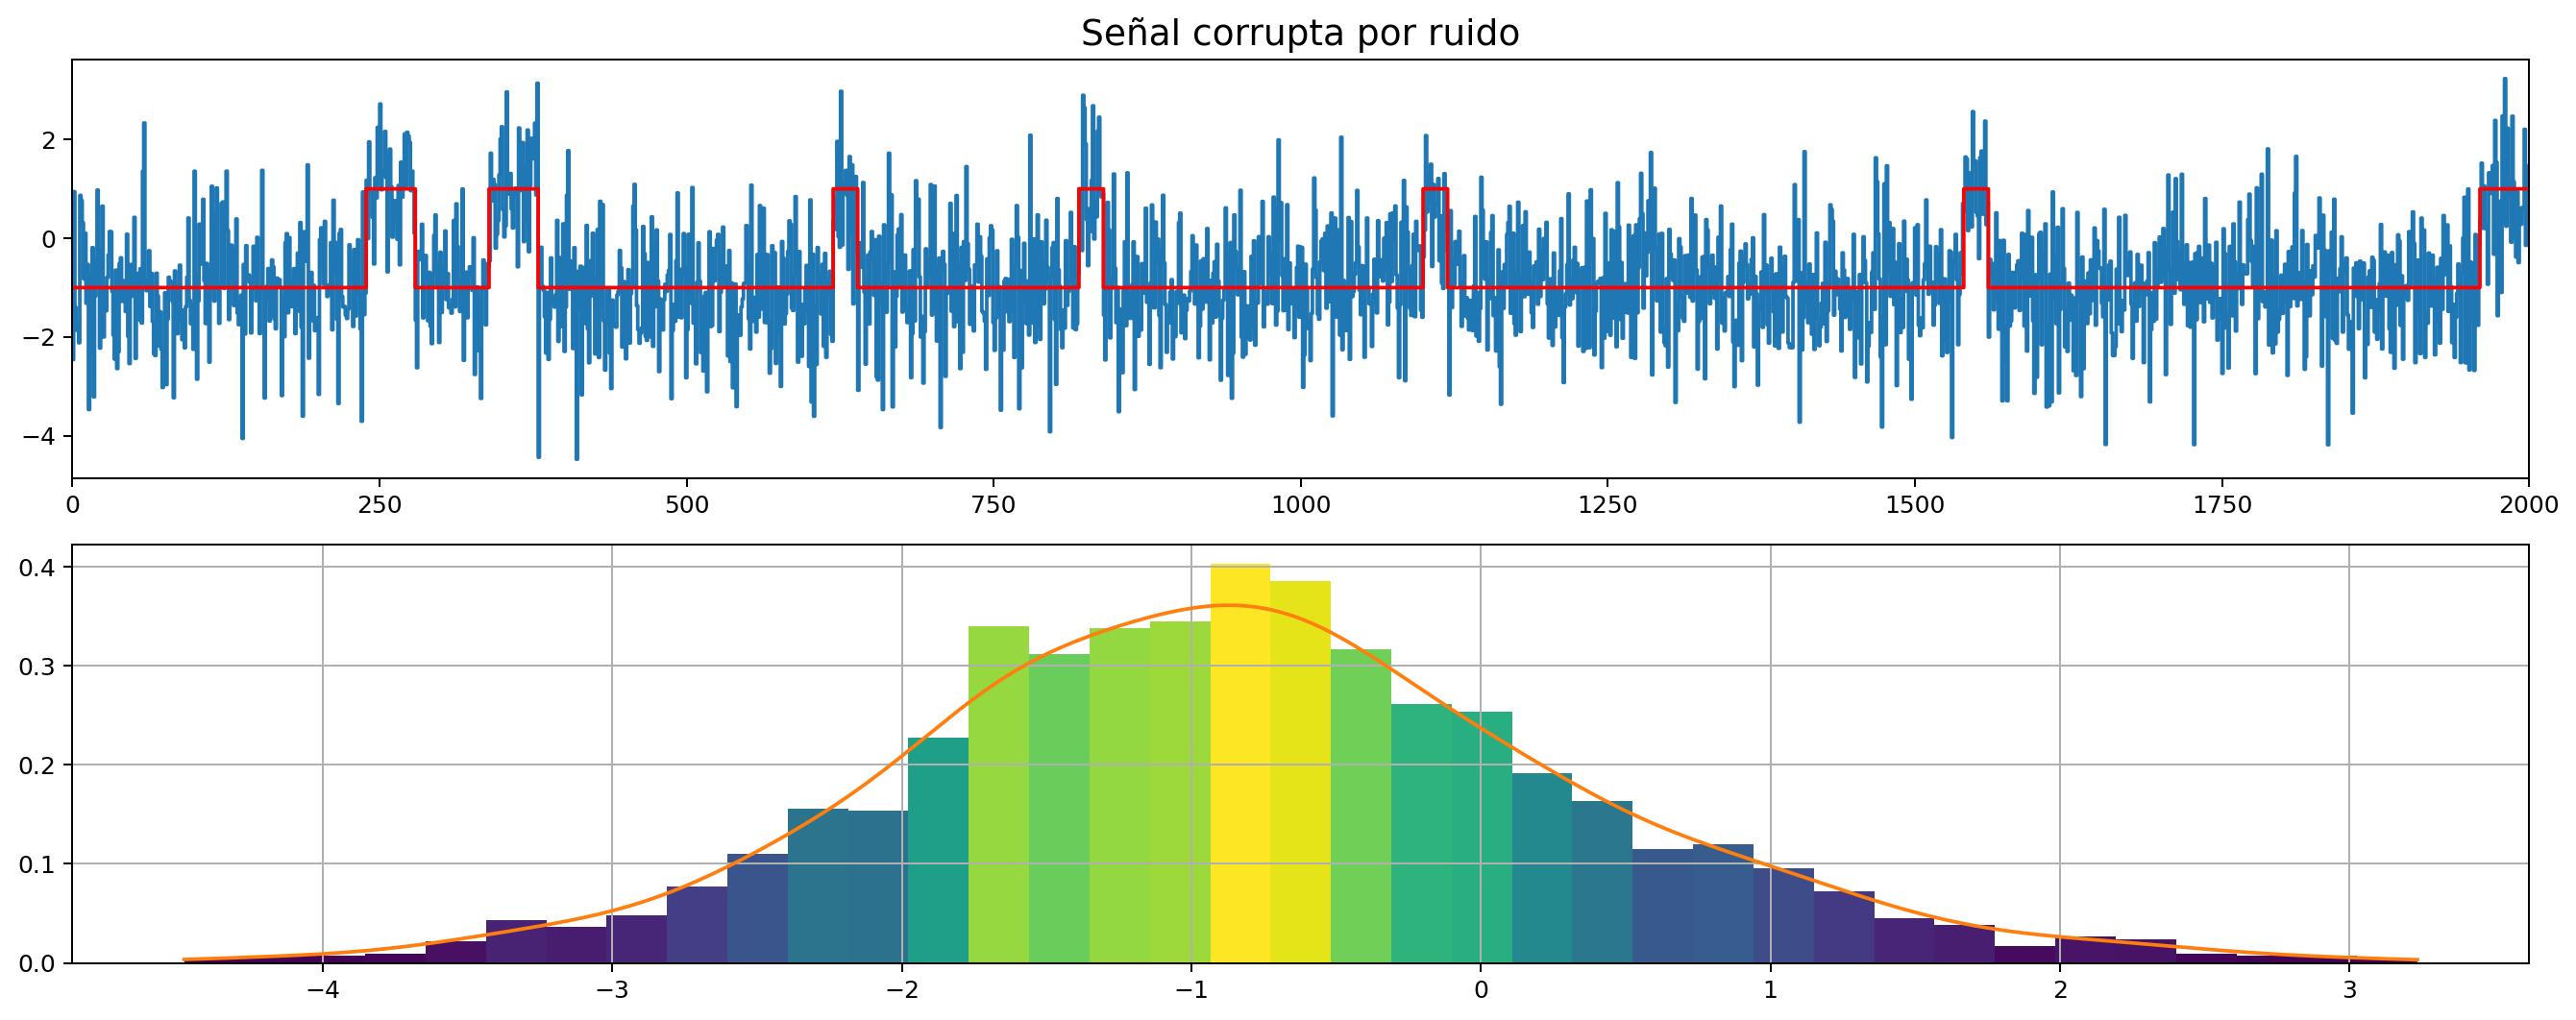

In [40]:
# Generación de la señal corrupta sumando el mensaje y el ruido
y = message + noise
y_pdf_x, y_pdf_y = kde_function(y)
fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time, y, '-')
ax[0].set_title('Señal corrupta por ruido')
ax[0].set_xlim(0, N)
ax[0].step(time, message, '-r')
coloredhist(y, plot=1)
ax[1].plot(y_pdf_x, y_pdf_y)
plt.show()

In [41]:
Test_Chi_Square(y)

Chi-Square Test
stat= -3277.102, p= 1.0
Probably Gaussian


(-3277.1023765882915, 1.0, True)

#### Rx
smoothing by a RC low-band pass filter

In [42]:
# Definición de parámetros para el filtro suavizante
R = 3000
C = .0003
num = [1]
den = [R * C, 1]

# Obtención de la respuesta al impulso y función de transferencia del filtro
lti_system = lti(num, den)
t, h = lti_system.impulse(N)
coeff = fftshift(fft(h))
f = fftshift(fftfreq(coeff.shape[0], t[1] - t[0]))

# Aplicación del filtro a la señal corrupta
_, output0_, _ = lti_system.output(y, time)
output_pdf = kde_function(output0_)#, method = "Cross Validation")


Method:Silverman
Optimal bandwidth: 0.19


/tmp/ipykernel_4009/3505704059.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0] = plt.subplot(grid[0, 0])
/home/jony/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jony/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


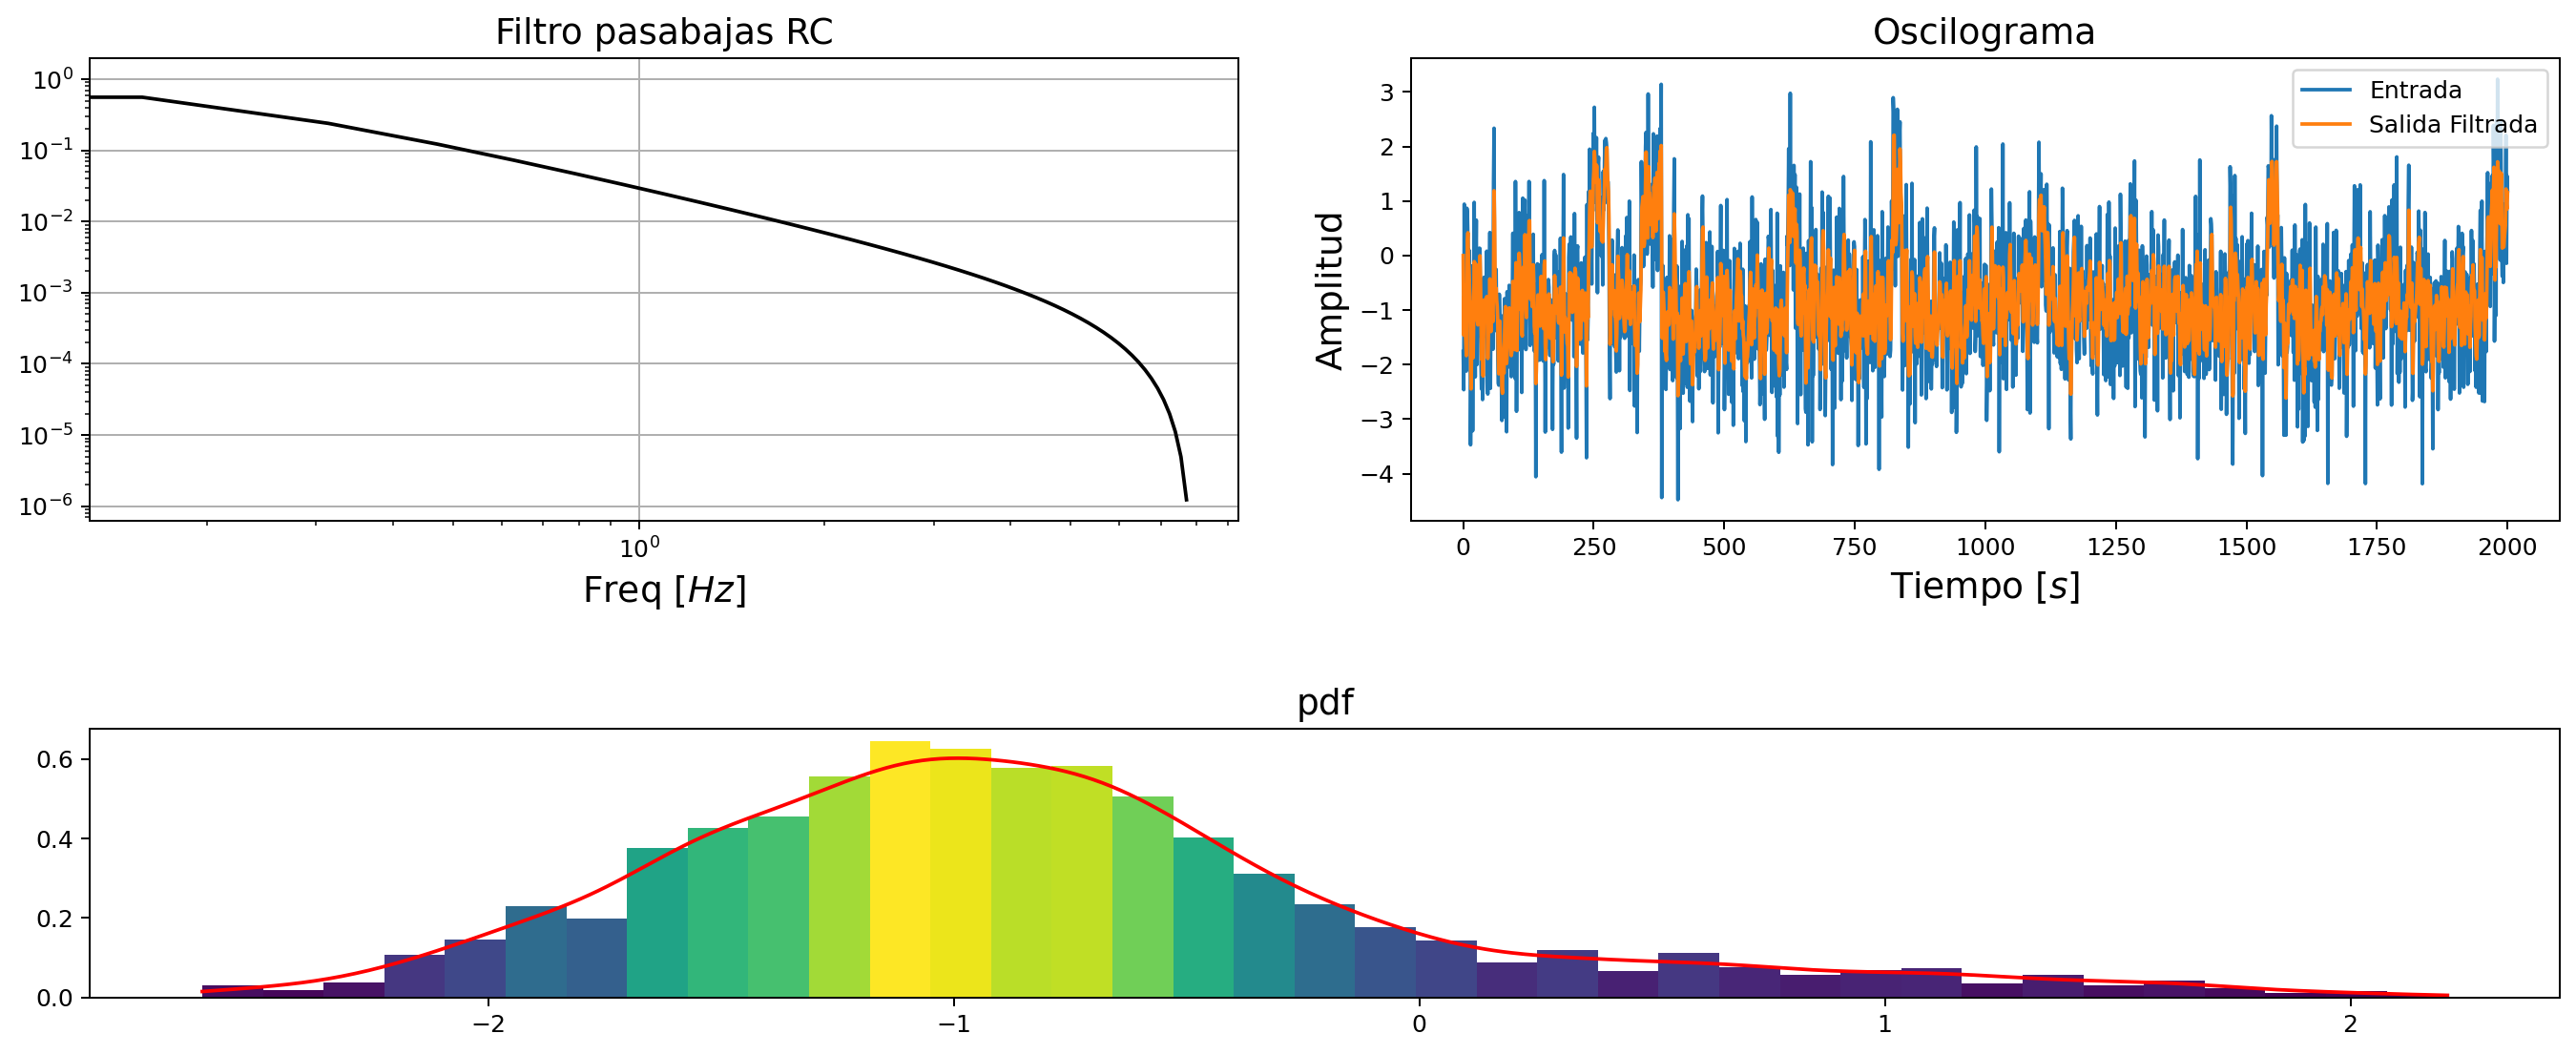

In [43]:
# Creación de gráficos
fig, ax = plt.subplots(3, 1, tight_layout=True)

# Configuración de la disposición de los gráficos
grid = plt.GridSpec(2, 2, wspace=0.15, hspace=0.03)
ax[0] = plt.subplot(grid[0, 0])
ax[0].set_title('Filtro pasabajas RC')
# Visualización de la respuesta en frecuencia del filtro
ax[0].loglog(f, norMaxMin(coeff), 'k')
ax[0].set_xlabel('Freq [$Hz$]')
ax[0].grid()

ax[1] = plt.subplot(grid[0, 1])
# Visualización del oscilograma de las señales de entrada y salida del filtro
ax[1].plot(time, y, label='Entrada')
ax[1].plot(time, output0_, label='Salida Filtrada')
ax[1].set_title('Oscilograma')
#ax[1].set_xlim(0, Nsamples/2)
ax[1].grid(True)
ax[1].set_xlabel('Tiempo [$s$]')
ax[1].set_ylabel('Amplitud')

# Visualización de la pdf estimada de la señal filtrada
ax[2].set_title('pdf')
ax[2].plot(output_pdf[0], output_pdf[1],color='r')
coloredhist(output0_, plot=2)
plt.legend()
plt.show()

$\varLambda (y)=  {{p(y|a_1 )}}/{{p(y|a_0 )}} \textrm{   Likelihood ratio}$

In [44]:
def error_umbral(umbral,S0,S1):
    # Filtrar los datos dentro de los límites de integración

    Error = []
    std = np.sqrt(σ2)
    S0_pdf = S1
    S1_pdf = S0

    for u in umbral:

        ainf_0 = a1-6*std
        true_values_0 = (S0_pdf[0] >= ainf_0) & (S0_pdf[0] <= u)

        y0_pdf = S0_pdf[1][true_values_0]
        x0_pdf = S0_pdf[0][true_values_0]

        h_0 = np.diff(x0_pdf)  # Calcula el ancho de cada subintervalo
        int_1 = 0.5 * h_0 * (y0_pdf[:-1] + y0_pdf[1:])  # Calcula el área de cada trapecio
        int_1 = np.sum(int_1)

        ainf_1 = a0+6*std
        true_values_1 = (S1_pdf[0] >= u) & (S1_pdf[0] <= ainf_1)

        y1_pdf = S1_pdf[1][true_values_1]
        x1_pdf = S1_pdf[0][true_values_1]

        h_1 = np.diff(x1_pdf)  # Calcula el ancho de cada subintervalo
        int_2 = 0.5 * h_1 * (y1_pdf[:-1] + y1_pdf[1:])  # Calcula el área de cada trapecio
        int_2 = np.sum(int_2)

        Error.append(p_0 * int_1 + p_1 * int_2)

    return Error[::-1]

Simbol_0 = a0 + noise #np.random.normal(a0,np.sqrt(σ2),N)
Simbol_1 = a1 + noise #np.random.normal(a1,np.sqrt(σ2),N)

x_min= min(np.min(Simbol_0),np.min(Simbol_1))
x_max= max(np.max(Simbol_0),np.max(Simbol_1))

x=np.linspace(x_min,x_max,1000)

S0_pdf = kde_function(Simbol_0,eval_points = x)#, method="Cross Validation")
S1_pdf = kde_function(Simbol_1, eval_points = x)#, method="Cross Validation")
umbral = kde_function(output0_, eval_points = x)#, method="Cross Validation")

error = error_umbral(umbral[0],S0_pdf,S1_pdf)

ideal_umbral = umbral[0][np.argmin(error)]
min_error = error[np.argmin(error)]
print(f'umbral ideal: {round(ideal_umbral,4)}\nError: {min_error}')


Method:Silverman
Optimal bandwidth: 0.23
Method:Silverman
Optimal bandwidth: 0.23
Method:Silverman
Optimal bandwidth: 0.19
umbral ideal: 1.0446
Error: 0.07714096018050896


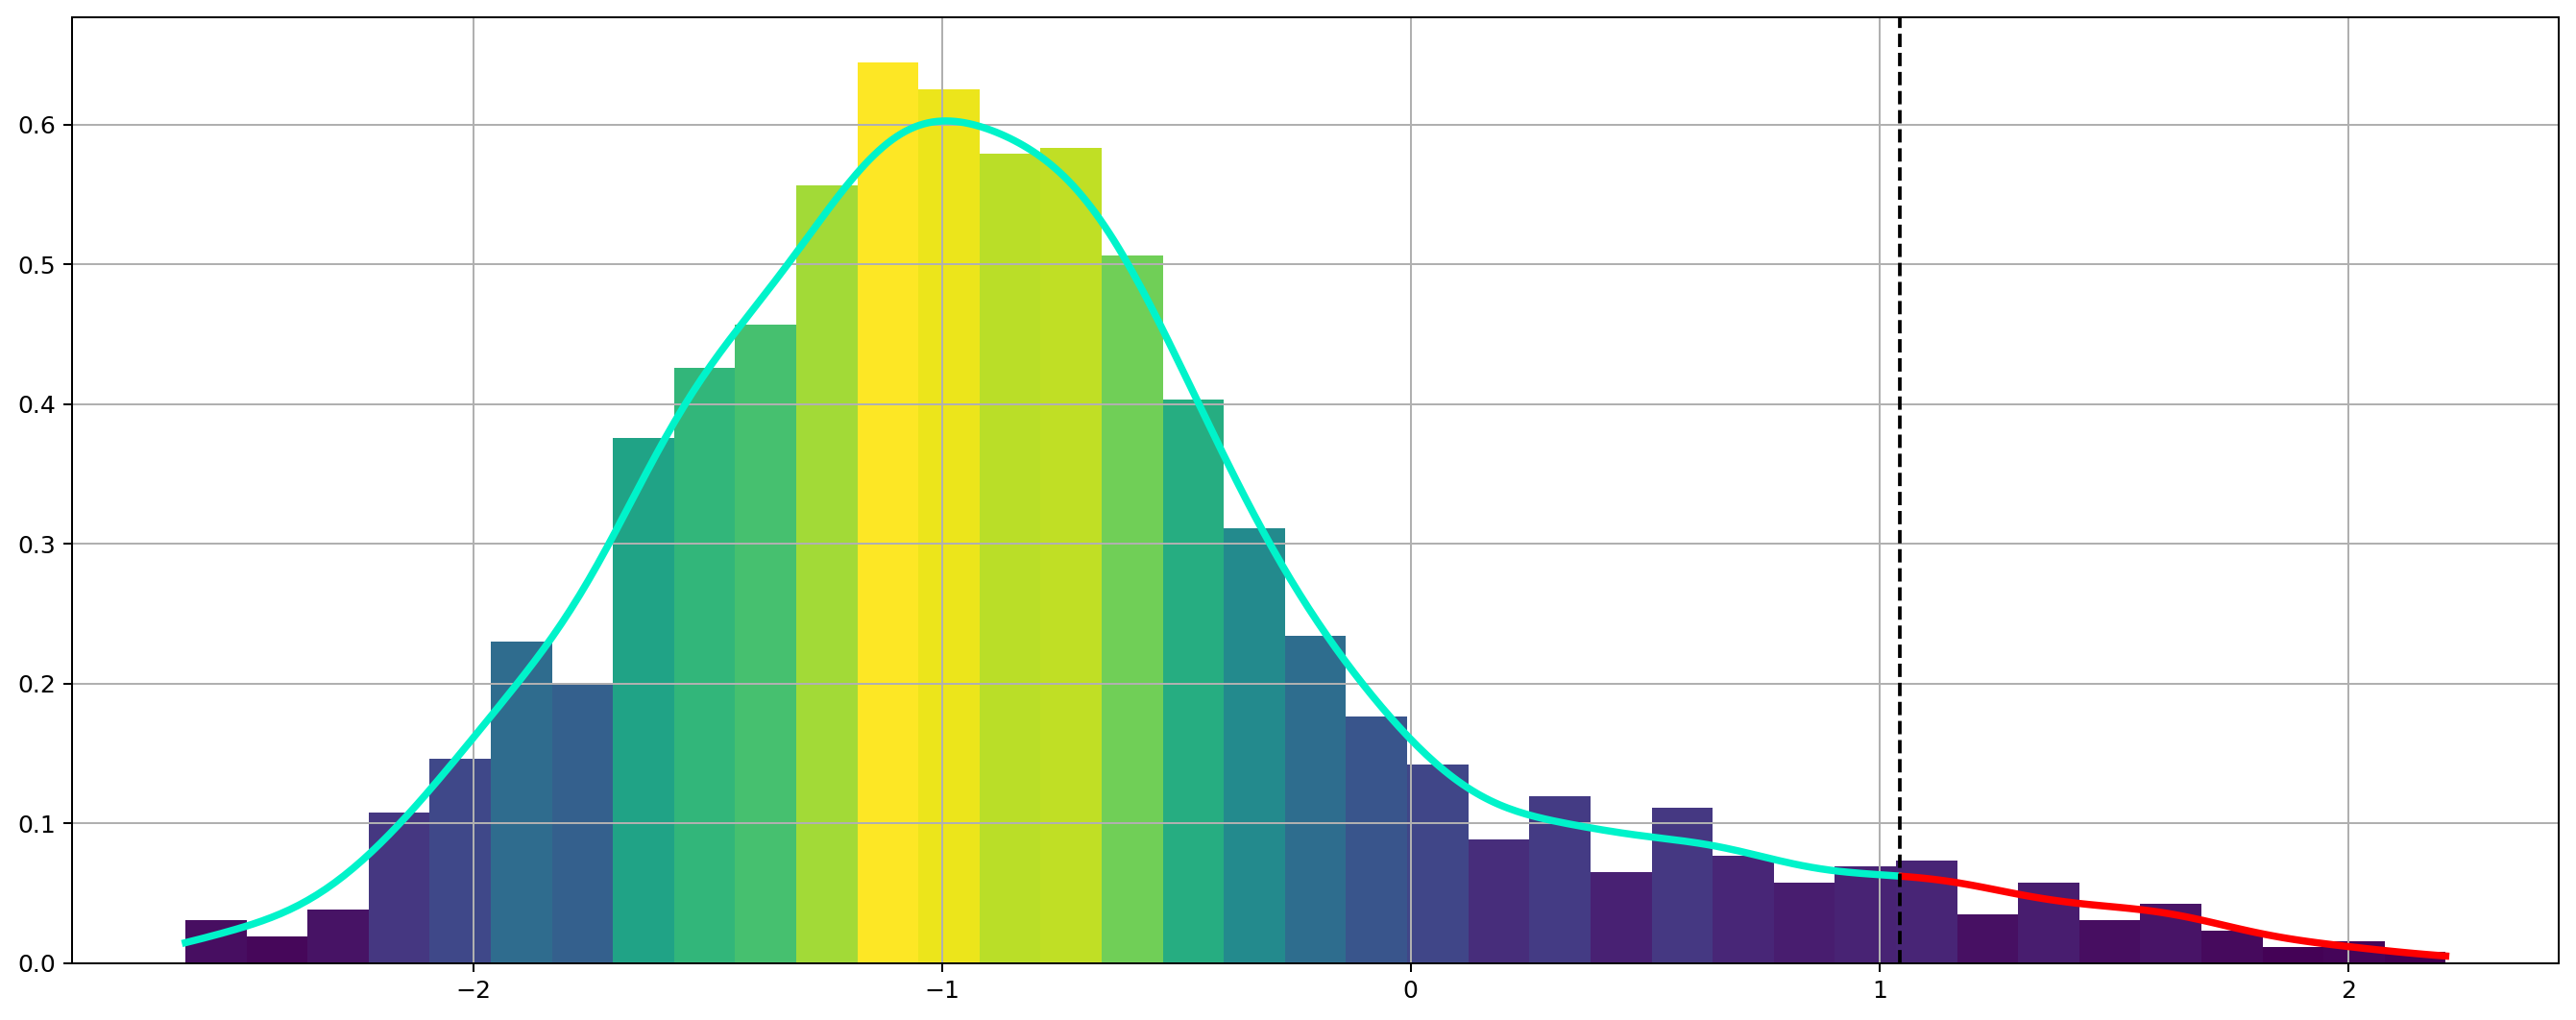

In [45]:
pdf_out = output_pdf[1]
evals_pdf = output_pdf[0]
message_S0 = pdf_out[evals_pdf<=ideal_umbral]
message_S1 = pdf_out[evals_pdf>=ideal_umbral]

message_S0_pdf = message_S0
message_S1_pdf = message_S1


#---------------[Reales]-------------------
# Calcula la pdf de la señal corrupta para cada valor de símbolo
std = np.sqrt(σ2)
y1 = S1_pdf[1]
y1 = y1 * p_1
y0 = S0_pdf[1]
y0 = y0 * p_0
y = umbral[0]

plt.show()


fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.plot(evals_pdf[:len(message_S0)],message_S0_pdf,color='#00f3ca', linewidth=3)
ax.plot(evals_pdf[len(message_S0):],message_S1_pdf,'r', linewidth=3)

ax.axvline(x=ideal_umbral, color='k', linestyle='--')

#ax.plot(evals_pdf,pdf_out)
#ax.plot(y,y0,'b')
#ax.plot(y,y1,'y')
coloredhist(output0_)
plt.show()

Method:Silverman
Optimal bandwidth: 0.16
Method:Silverman
Optimal bandwidth: 0.13


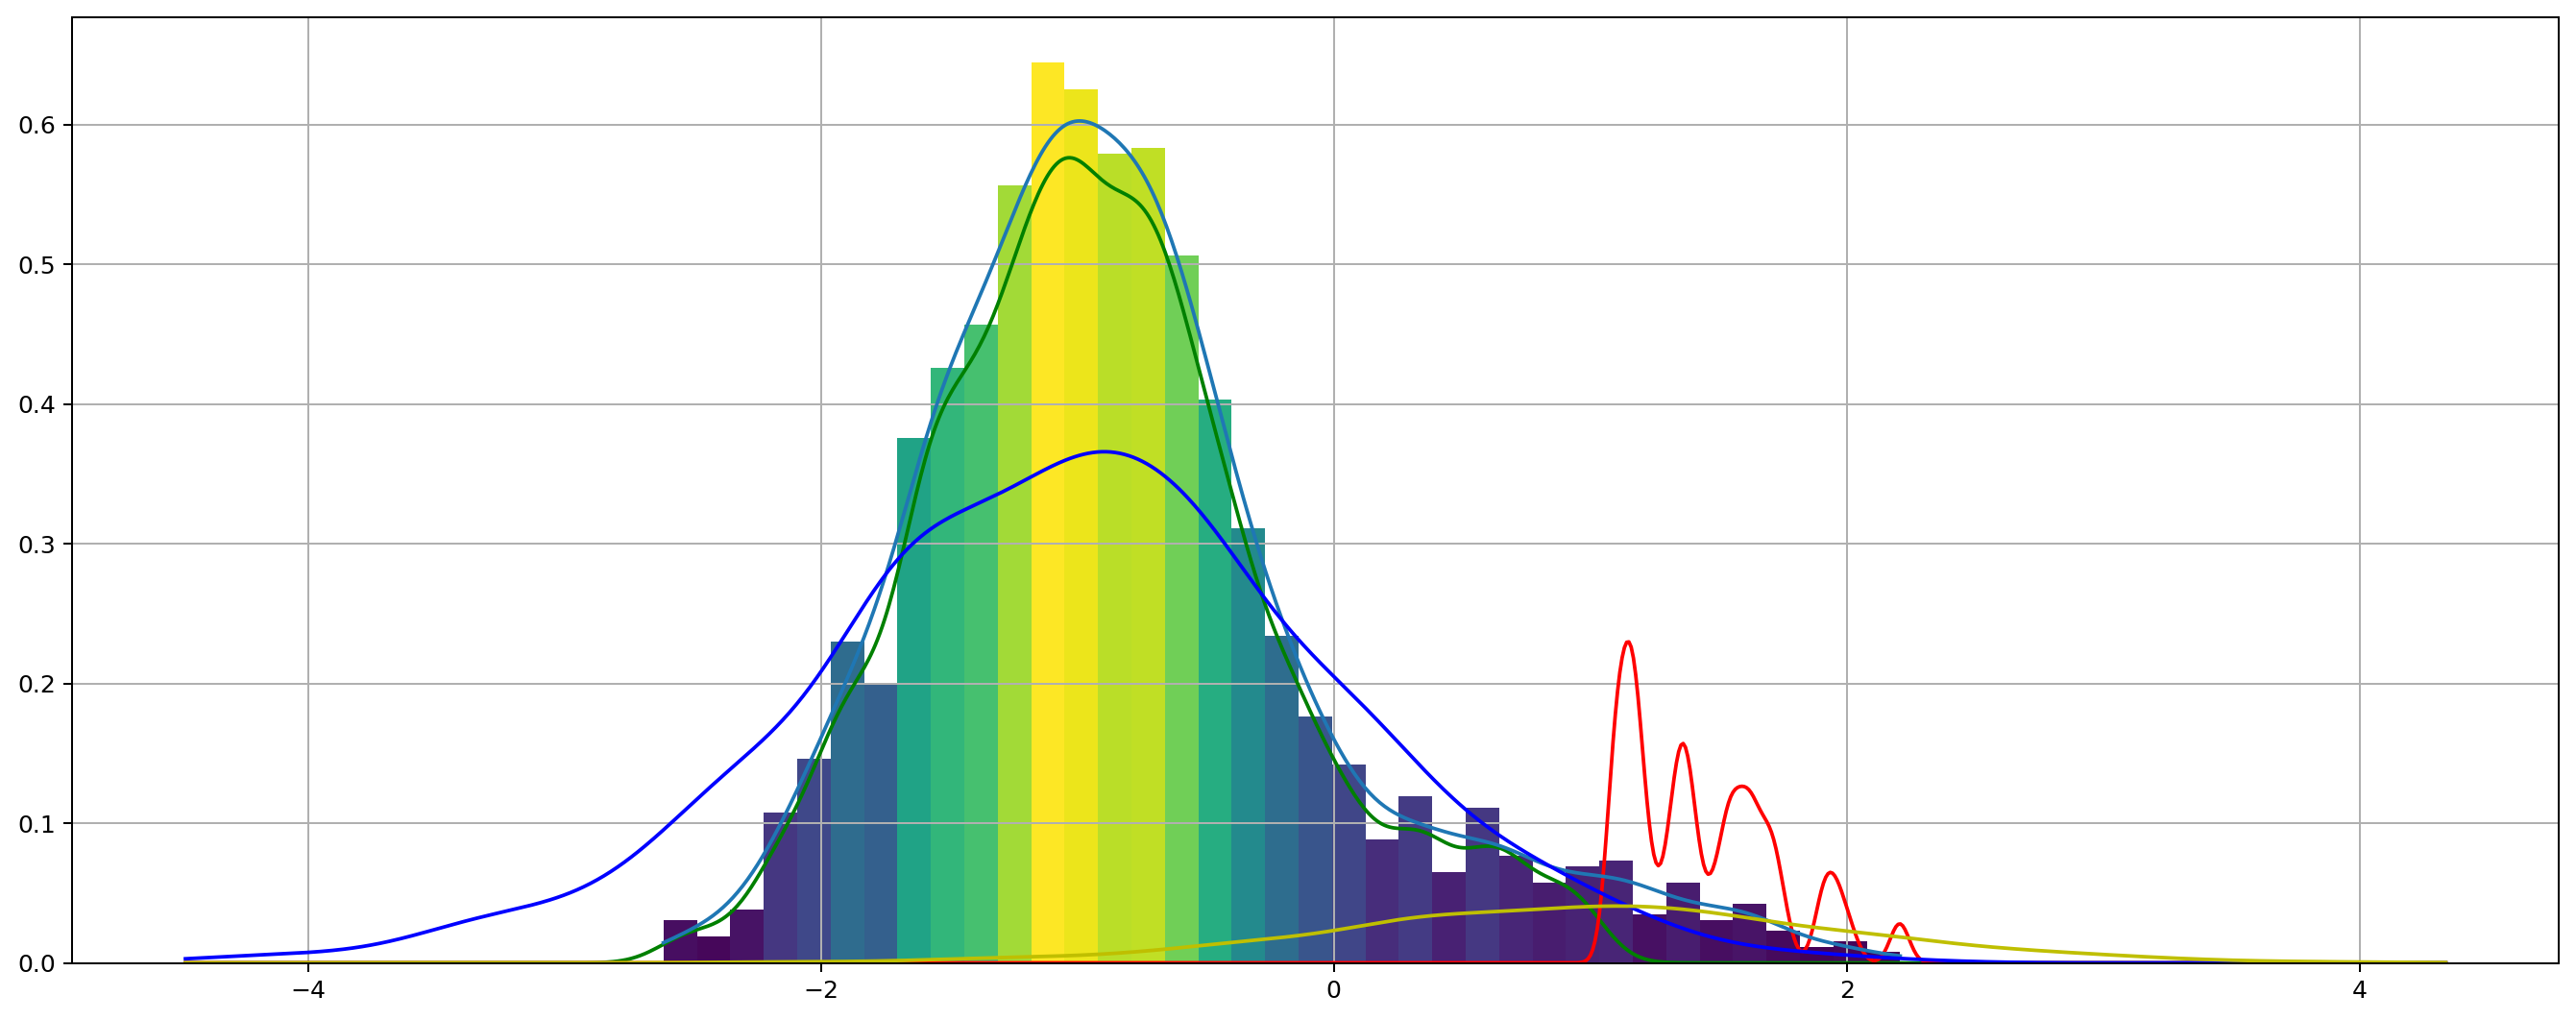

In [46]:
message_S0 = output0_[output0_<=ideal_umbral]
message_S1 = output0_[output0_>=ideal_umbral]

message_S0_pdf = kde_function(message_S0, eval_points = x)
message_S1_pdf = kde_function(message_S1, eval_points = x)

#---------------[Reales]-------------------
# Calcula la pdf de la señal corrupta para cada valor de símbolo
std = np.sqrt(σ2)
y1 = S1_pdf[1]*p_1
y0 = S0_pdf[1]*p_0
y = umbral[0]

plt.show()


fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.plot(x,message_S0_pdf[1]*p_0,'g')
ax.plot(x,message_S1_pdf[1]*p_1,'r')
ax.plot(output_pdf[0],output_pdf[1])
ax.plot(y,y0,'b')
ax.plot(y,y1,'y')
coloredhist(output0_)
plt.show()

Threshold computation

In [47]:
@interact(u=(umbral[0][1], umbral[0][-1], 0.1))
def umbral_interact(u=ideal_umbral):
    """
    Función interactiva que permite al usuario ajustar un umbral y visualizar
    cómo afecta a la estimación de la pdf de la señal y al error resultante.

    Parámetros:
    - u: Valor de umbral seleccionado por el usuario.
    """
    plt.figure()  # Creación de una nueva figura
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.grid(True)

    # Visualización de las regiones de decisión basadas en el umbral
    plt.fill_between(y[y>u], y1[y>u], color='#F0F', zorder=90)
    plt.fill_between(y[y>u], y0[y>u], color='#A0A', zorder=90)
    plt.fill_between(y[y<u], y0[y<u], color='#0FF', zorder=90)
    plt.fill_between(y[y<u], y1[y<u], color='#0AA', zorder=90)

    # Visualización de las estimaciones de pdf
    plt.plot(y, y1, linestyle='--', color='w', zorder=99)
    plt.plot(y, y0, linestyle='--', color='w', zorder=99)

    # Línea vertical indicando el umbral seleccionado
    plt.vlines(u, 0, 0.12, color='k', linestyle='--', zorder=100)

    ax2 = plt.subplot2grid((3, 1), (2, 0))
    plt.grid(True)

    # Visualización del error en función del umbral
    xerror = np.linspace(y[0], y[-1], len(error))
    error_ = np.array(error)
    error_value = error[(abs(y-u)).argmin()]
    plt.plot(xerror, error_, color='C3', label=f'Error: {error_value:0.2f}')
    plt.vlines(u, error_.min(), error_.max(), color='k', linestyle='--')
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Umbral')
    plt.show()

interactive(children=(FloatSlider(value=1.0446361441880692, description='u', max=4.335673777841514, min=-4.469…

In [48]:
from scipy.optimize import minimize_scalar

# Asumiendo que el costo de los errores de tipo I y II es el mismo
cost_type_i = 1
cost_type_ii = 1

# Función para calcular la probabilidad de error para un dado umbral
def error_probability(threshold):
    dx = output_pdf[0][1]-output_pdf[0][0]
    # Probabilidad de error de tipo I: P(Detectar incendio | No hay incendio)
    prob_type_i = np.sum(output_pdf[1][output_pdf[0] < threshold]) * cost_type_i*dx
    # Probabilidad de error de tipo II: P(No detectar incendio | Hay incendio)
    prob_type_ii = np.sum(output_pdf[1][output_pdf[0] > threshold]) * cost_type_ii*dx
    return prob_type_i+prob_type_ii

# Encuentra el umbral que minimiza la probabilidad de error
result = minimize_scalar(error_probability, bounds=(-2, 2), method='bounded')

# Umbral óptimo de decisión
optimal_threshold1 = result.x
print(optimal_threshold1)

0.7151542708264965


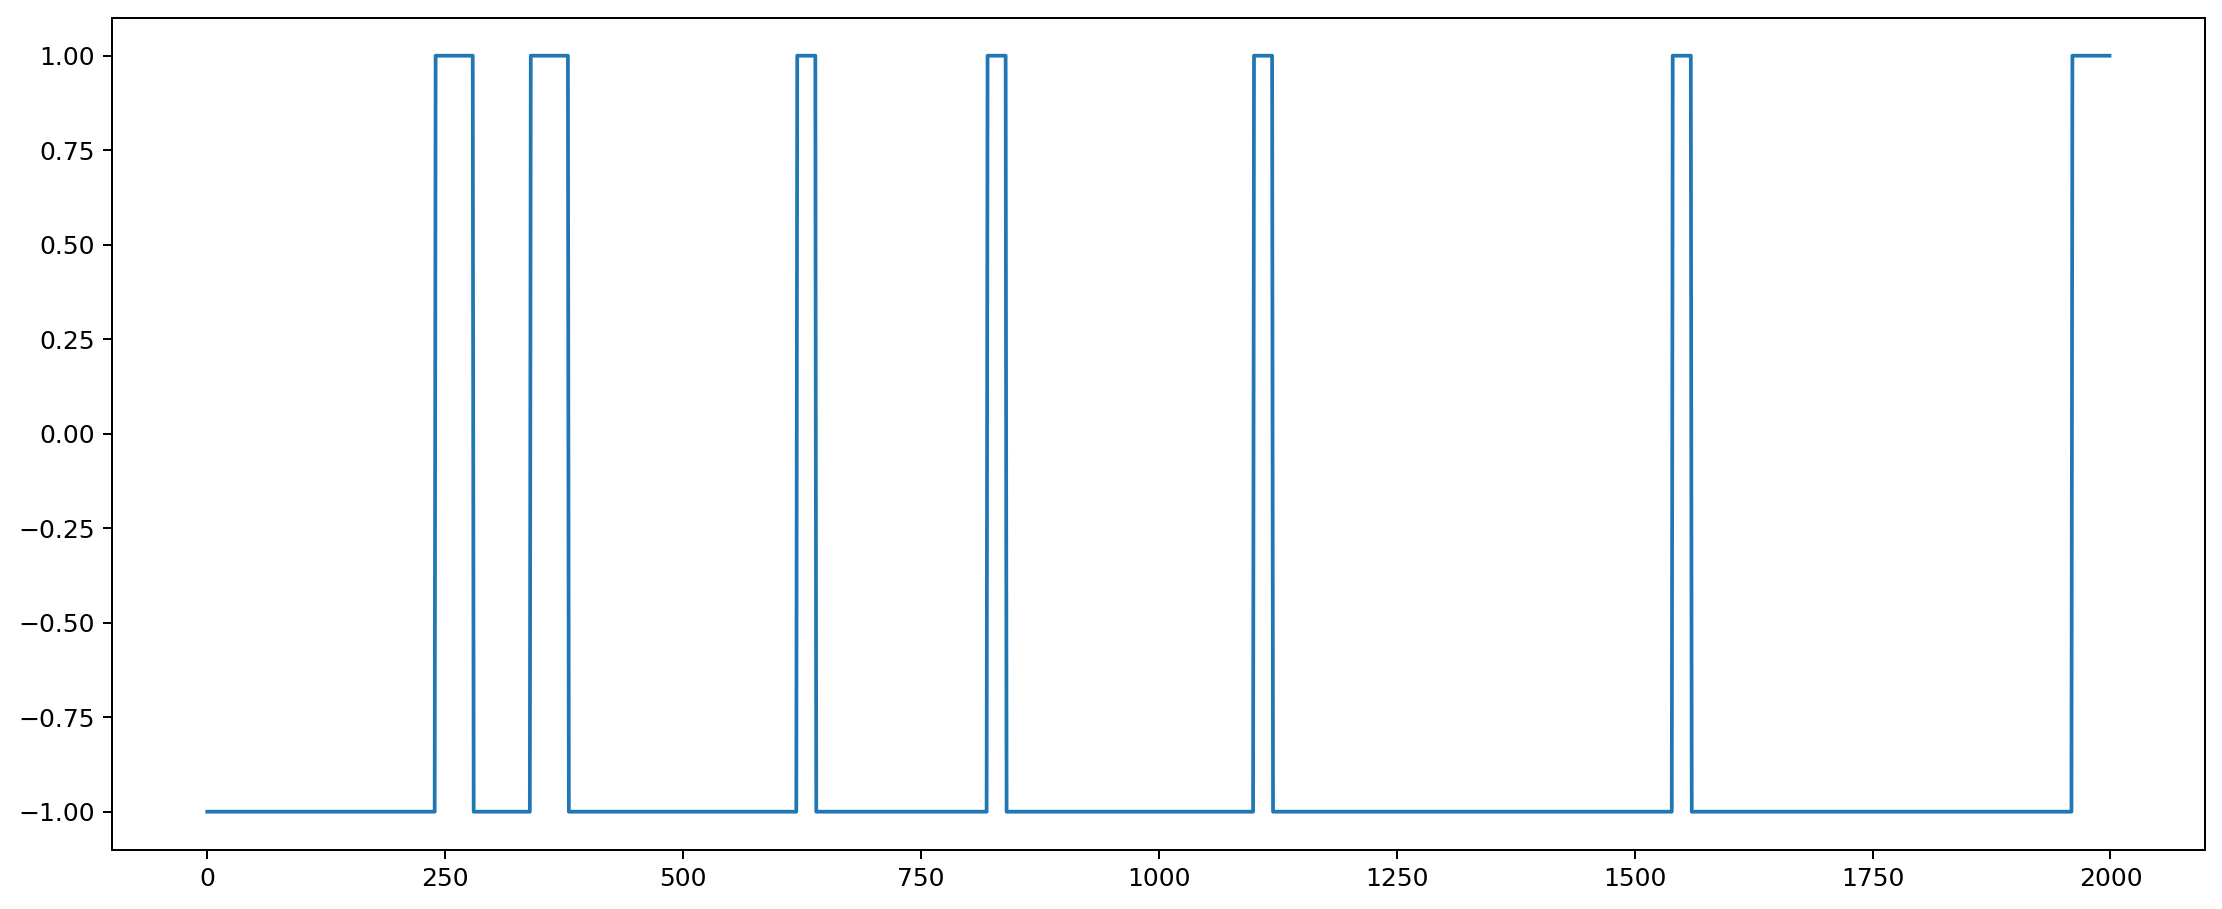

In [49]:
plt.plot(message)

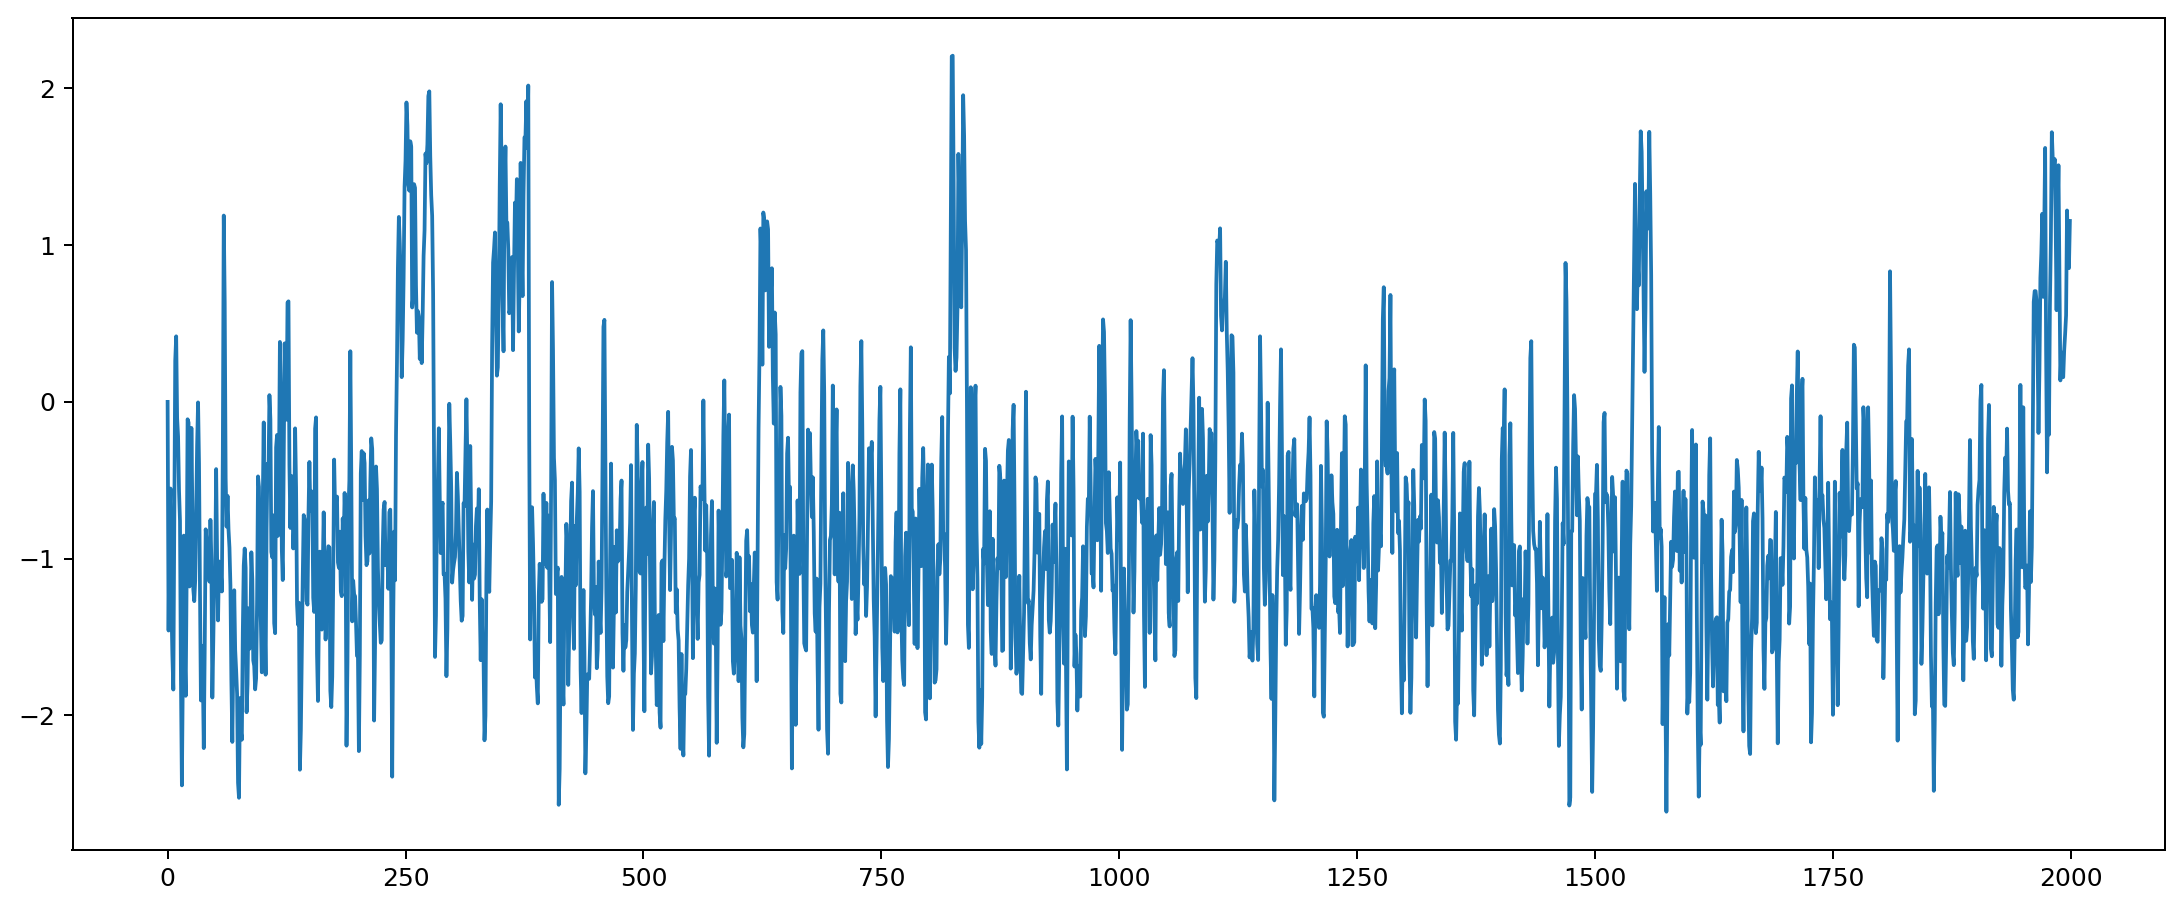

In [50]:
plt.plot(output0_)

5
89


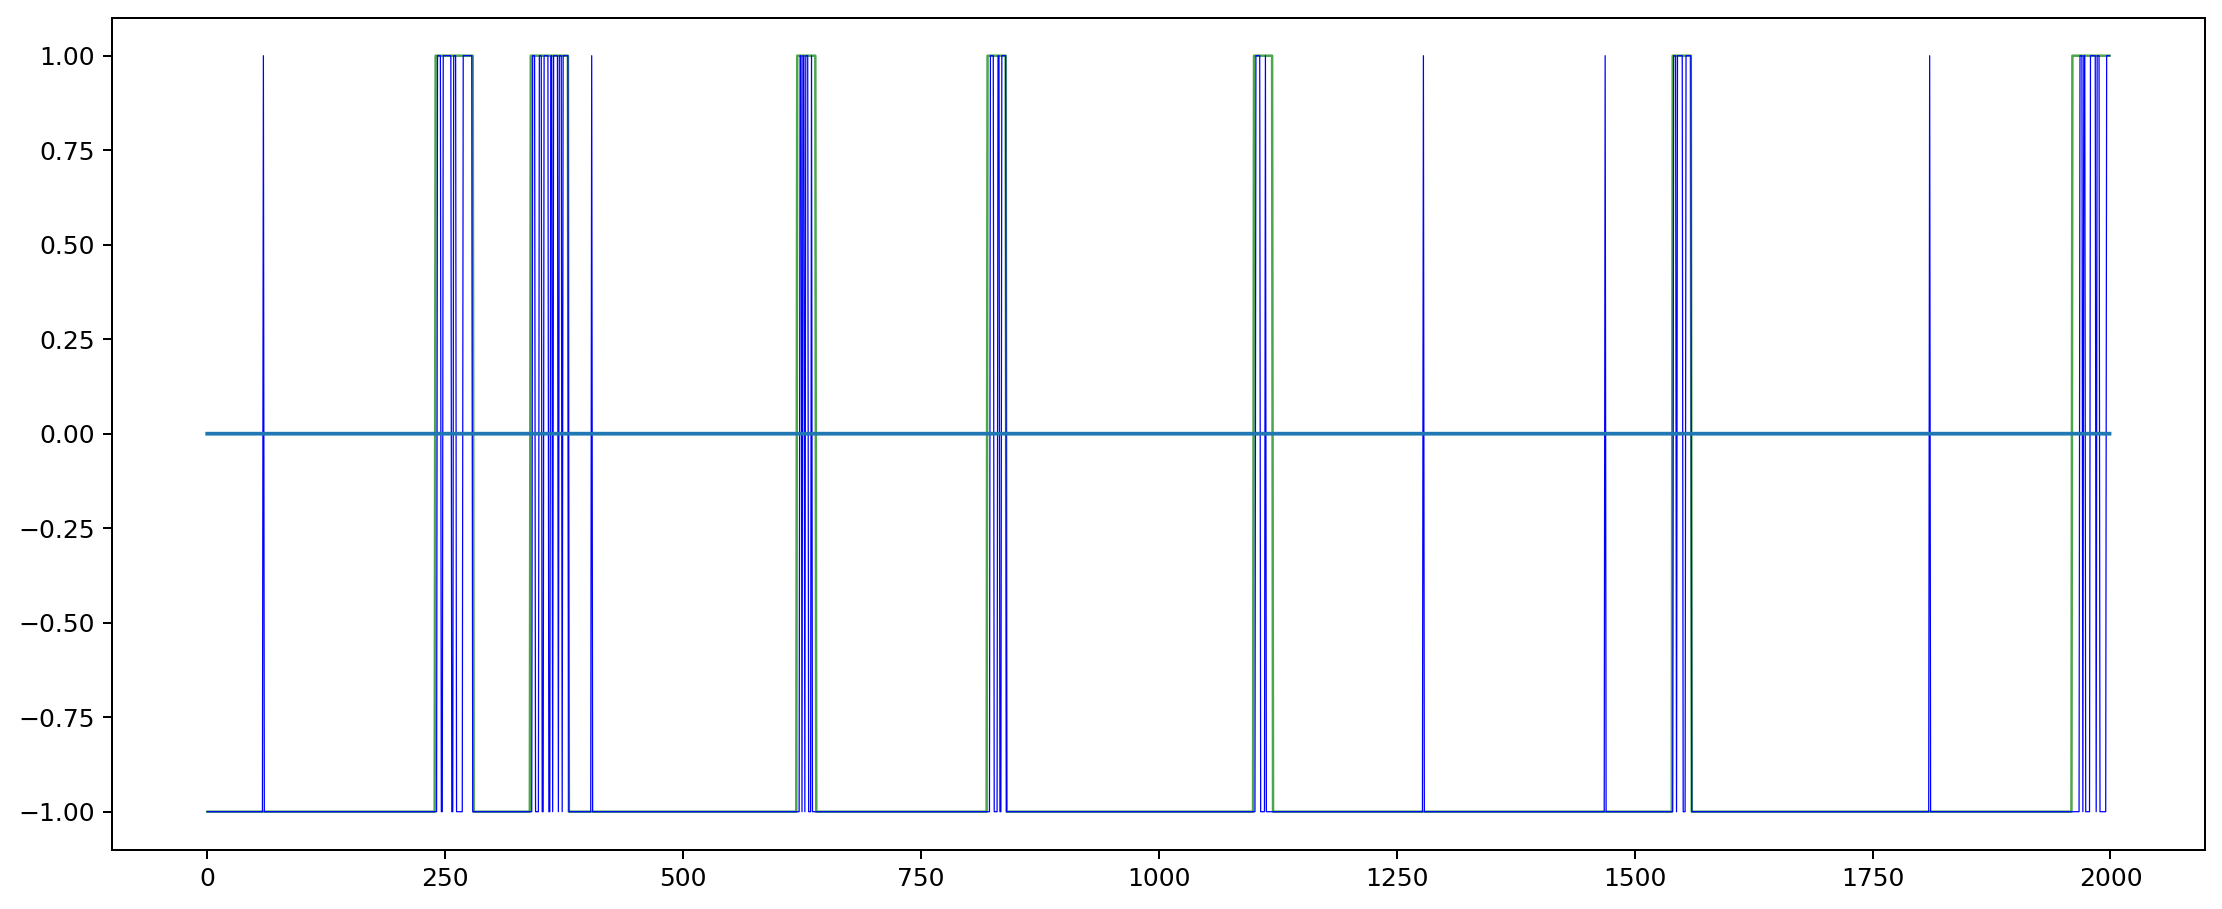

In [51]:
ideal_umbral = optimal_threshold1
message_S0 = output0_[output0_<=ideal_umbral]
message_S1 = output0_[output0_>=ideal_umbral]

signal_detection = [-1 if value <= ideal_umbral else 1 for value in output0_]

#message_S0_pdf = kde_function(message_S0, eval_points = x)
#message_S1_pdf = kde_function(message_S1, eval_points = x)




#fig, ax = plt.subplots(1, 1, tight_layout=True)

center = np.zeros(len(message))
#ax.plot(message_S0)
#ax.plot(message_S1)



#ax.plot(x,message_S0_pdf[1]*p_0,'g')#ax.plot(x,message_S1_pdf[1]*p_1,'r')
#ax.plot(output_pdf[0],output_pdf[1])
#ax.plot(y,y0,'b')
#ax.plot(y,y1,'y')
#coloredhist(output0_)
plt.show()



if len(message) == len(signal_detection):

    error_a0 = 0 
    error_a1 = 0

    cont=0

    for a,b in zip(message,signal_detection):

        if a == a0 and b == 1:
            error_a0 += 1

        elif a == a1 and b == -1:
            error_a1 += 1

        cont+=1

else:
    print('error')

print(error_a0)
print(error_a1)   


plt.plot(message, color = "green",linewidth=1, alpha=0.7)
plt.plot(signal_detection, color="blue", linewidth=0.5, alpha=1)
plt.plot(center)



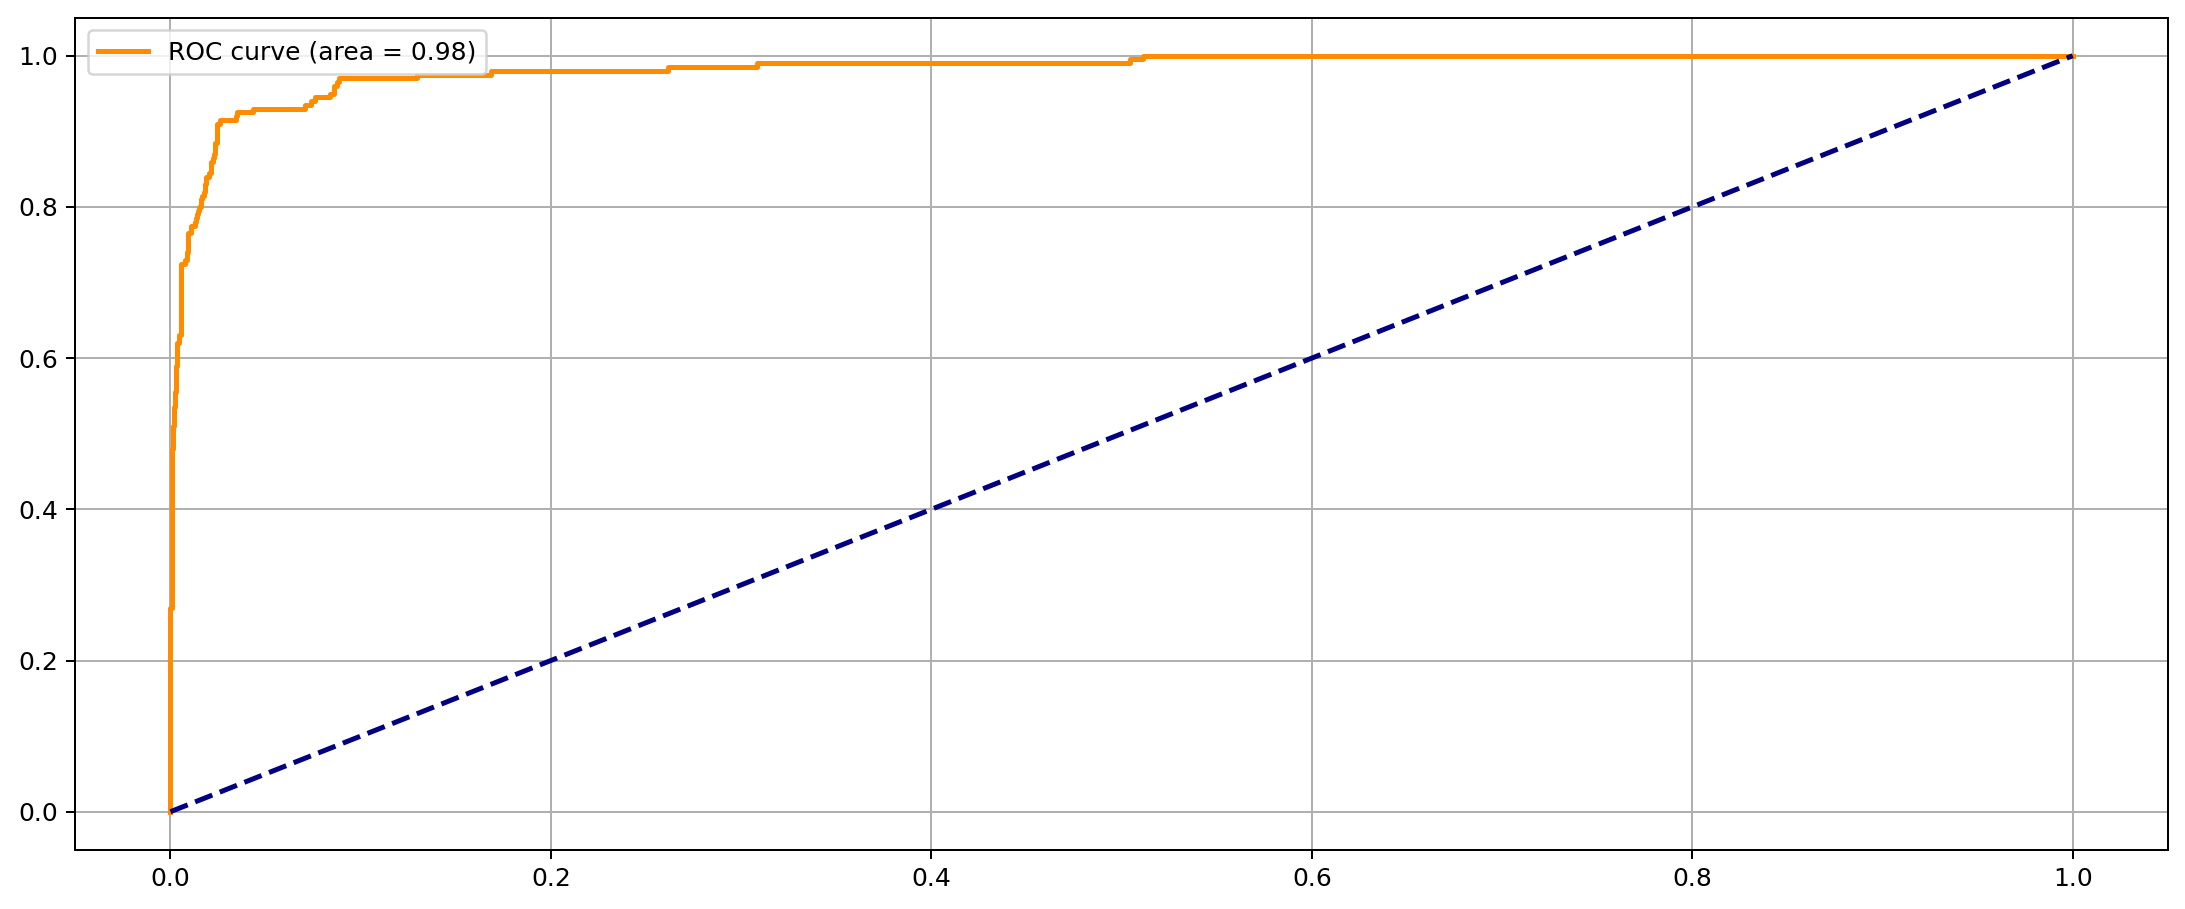

El umbral óptimo es: 0.006215942665730322
tpr: 0.93
fpr: 0.043333333333333335


In [52]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(message, output0_)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import roc_curve, auc
import numpy as np


# Calculamos la distancia al punto ideal (0,1) para cada par de TPR y FPR
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)

# Encontramos el índice del punto con la distancia mínima
min_distance_idx = np.argmin(distances)

# El umbral óptimo es el umbral correspondiente a este punto
optimal_threshold2 = thresholds[min_distance_idx]

print(f"El umbral óptimo es: {optimal_threshold2}")
print(f'tpr: {tpr[min_distance_idx]}')
print(f'fpr: {fpr[min_distance_idx]}')



In [56]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity

# Supongamos que signal_x es tu conjunto de datos unidimensional
signal_x = output0_  # tus datos aquí

# Definir los posibles valores para el ancho de banda
bandwidths = np.arange(0.05, 2, 0.05) # por ejemplo

# Inicializar el mejor log likelihood a un valor muy bajo
best_log_likelihood = -np.inf
best_bandwidth = None

# Dividir los datos usando KFold
kf = KFold(n_splits=5)

# Proceso de validación cruzada manual
for bandwidth in bandwidths:
    log_likelihoods = []
    
    for train_index, test_index in kf.split(signal_x):
        # Dividir en conjunto de entrenamiento y validación
        X_train, X_test = signal_x[train_index], signal_x[test_index]

        # Ajustar el modelo KDE con el ancho de banda actual
        kde = KernelDensity(bandwidth=bandwidth)
        kde.fit(X_train.reshape(-1, 1))

        # Calcular el log likelihood en el conjunto de validación
        log_likelihood = kde.score(X_test.reshape(-1, 1))
        log_likelihoods.append(log_likelihood)

    # Calcular el log likelihood promedio para este ancho de banda
    avg_log_likelihood = np.mean(log_likelihoods)

    # Actualizar el mejor ancho de banda si es necesario
    if avg_log_likelihood > best_log_likelihood:
        best_log_likelihood = avg_log_likelihood
        best_bandwidth = bandwidth

# Resultado
print(f'Best bandwidth: {best_bandwidth}')

Best bandwidth: 0.15000000000000002


In [54]:
kde_function(output0_, method="Cross Validation")

Optimal bandwidth: 0.15


(array([-2.61445549, -2.60479044, -2.59512539, -2.58546034, -2.57579529,
        -2.56613024, -2.55646519, -2.54680014, -2.53713509, -2.52747004,
        -2.517805  , -2.50813995, -2.4984749 , -2.48880985, -2.4791448 ,
        -2.46947975, -2.4598147 , -2.45014965, -2.4404846 , -2.43081955,
        -2.4211545 , -2.41148945, -2.40182441, -2.39215936, -2.38249431,
        -2.37282926, -2.36316421, -2.35349916, -2.34383411, -2.33416906,
        -2.32450401, -2.31483896, -2.30517391, -2.29550887, -2.28584382,
        -2.27617877, -2.26651372, -2.25684867, -2.24718362, -2.23751857,
        -2.22785352, -2.21818847, -2.20852342, -2.19885837, -2.18919332,
        -2.17952828, -2.16986323, -2.16019818, -2.15053313, -2.14086808,
        -2.13120303, -2.12153798, -2.11187293, -2.10220788, -2.09254283,
        -2.08287778, -2.07321273, -2.06354769, -2.05388264, -2.04421759,
        -2.03455254, -2.02488749, -2.01522244, -2.00555739, -1.99589234,
        -1.98622729, -1.97656224, -1.96689719, -1.9